<a href="https://colab.research.google.com/github/siqisiqisiqisiqi/deep-learning-hw1/blob/main/hw1_3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.conv import Conv2d
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
n_epochs = 3
batch_size_train = 1024 
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

In [ ]:
training_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform=Compose([ToTensor(),Normalize((0.1307,),(0.3081,))])
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=Compose([ToTensor(),Normalize((0.1307,),(0.3081,))])
)

In [ ]:
def caculate_sensitivity():
  norm = 0
  # with torch.no_grad():
  for x, y in test_loader:
    x.requires_grad = True
    network.eval()
    output = network(x)
    test_loss = F.nll_loss(output, y, size_average=False)
    optimizer.zero_grad()
    test_loss.backward()
    ans = x.grad
    ans = ans.numpy()
    ans2 = 0
    for i in range(len(ans)):
      a = ans[i,0,:,:]
      ans2 += np.linalg.norm(a,'fro')
    norm += ans2/len(ans)
  return norm

In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self):
      super(NeuralNetwork, self).__init__()
      self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
      self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
      self.conv2_drop = nn.Dropout2d()
      self.fc1 = nn.Linear(320, 50)
      self.fc2 = nn.Linear(50, 10)
  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x),2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x)

In [ ]:
train_loader = DataLoader(training_data, batch_size=batch_size_train, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
def Accuracy(dataloader):
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in dataloader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  accu = 100. * correct / len(dataloader.dataset)
  return accu

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += loss_fn(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader)
  print('\n Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [ ]:
def train(epoch):
  # network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    network.train()
    optimizer.zero_grad()
    output = network(data)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
sensitivity_data = []
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
network = NeuralNetwork()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
batch_size_train = [64, 128, 256, 512, 1024, 2048]
for i in range(6):
  train_loader = DataLoader(training_data, batch_size=batch_size_train[i], shuffle=False)
  # test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)
  n_epochs = 3
  for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
  sensitivity = caculate_sensitivity()
  sensitivity_data.append(sensitivity)

  loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in train_loader:
      output = network(data)
      loss += loss_fn(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  accu = 100. * correct / len(train_loader.dataset)
  loss /= len(train_loader)
  train_losses.append(loss)
  train_accuracy.append(accu.item())

  loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      loss += loss_fn(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  accu = 100. * correct / len(test_loader.dataset)
  loss /= len(test_loader)
  test_losses.append(loss)
  test_accuracy.append(accu.item())

In [ ]:
torch.save(network.state_dict(), 'model6_weights.pth')

In [ ]:
torch.save(network.state_dict(), 'model7_weights.pth')

In [ ]:
test_losses = []
train_losses = []
test_accu = []
train_accu = []
weight1 = torch.load('model6_weights.pth')
weight2 = torch.load('model7_weights.pth')
for alpha in np.arange(-1.0,2.0,0.1):
  weight = {}
  for item in weight1:
    weight[item] = (1 - alpha)*weight1[item] + alpha*weight2[item]
  model = NeuralNetwork()
  model.load_state_dict(weight)
  model.eval()
  loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in train_loader:
      output = model(data)
      loss += loss_fn(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  accu = 100. * correct / len(train_loader.dataset)
  loss /= len(train_loader)
  train_losses.append(loss)
  train_accu.append(accu.item())

  loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      loss += loss_fn(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  accu = 100. * correct / len(test_loader.dataset)
  loss /= len(test_loader)
  test_losses.append(loss)
  test_accu.append(accu.item())
  print('Train alpha: {} '.format(alpha))

In [ ]:
train_loss_data = np.log(train_losses)
test_loss_data = np.log(test_losses)
print(len(test_loss_data))
time = np.arange(-1.0,2.0,0.1)
# time = np.arange(len(train_loss_data))
fig = plt.figure()
ax = fig.add_subplot(111)
p1, = ax.plot(time, train_loss_data,'-')
p2, = ax.plot(time, test_loss_data,'--')

ax2 = ax.twinx()
p3, = ax2.plot(time, train_accu, '-r')
p4, = ax2.plot(time, test_accu, '--b')

ax.set_xlabel("alpha")
ax.set_ylabel("loss in log")
ax2.set_ylabel("accueacy")

plt.legend([p1,p2,p3,p4],["train loss","test loss","train accuracy","test accuracy"])


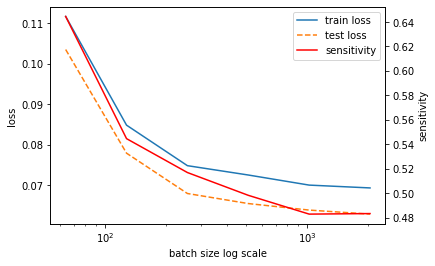

In [ ]:
# train_loss_data = np.log(train_losses)
# test_loss_data = np.log(test_losses)
# print(len(test_loss_data))
time = [64, 128, 256, 512, 1024, 2048]
# time = np.arange(len(train_loss_data))
fig = plt.figure()
ax = fig.add_subplot(111)
p1, = ax.plot(time, train_losses,'-')
p2, = ax.plot(time, test_losses,'--')
ax.set_xscale('log') 

ax2 = ax.twinx()
p3, = ax2.plot(time, sensitivity_data, '-r')
# p4, = ax2.plot(time, test_accu, '--b')
ax2.set_xscale('log') 

ax.set_xlabel("batch size log scale")
ax.set_ylabel("loss")
ax2.set_ylabel("sensitivity")

plt.legend([p1,p2,p3],["train loss","test loss","sensitivity"])

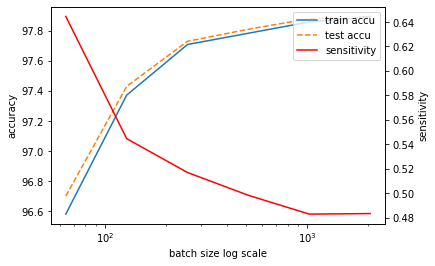

In [ ]:
# train_loss_data = np.log(train_losses)
# test_loss_data = np.log(test_losses)
# print(len(test_loss_data))
time = [64, 128, 256, 512, 1024, 2048]
# time = np.arange(len(train_loss_data))
fig = plt.figure()
ax = fig.add_subplot(111)
p1, = ax.plot(time, train_accuracy,'-')
p2, = ax.plot(time, test_accuracy,'--')
ax.set_xscale('log') 

ax2 = ax.twinx()
p3, = ax2.plot(time, sensitivity_data, '-r')
# p4, = ax2.plot(time, test_accu, '--b')
ax2.set_xscale('log') 

ax.set_xlabel("batch size log scale")
ax.set_ylabel("accuracy")
ax2.set_ylabel("sensitivity")

plt.legend([p1,p2,p3],["train accu","test accu","sensitivity"])

In [ ]:
print(train_losses)

[0.11167607005876201, 0.08485819082627737, 0.07486311047972041, 0.07256044673149363, 0.07007076506013588, 0.06937313837309679]
